<a href="https://colab.research.google.com/github/pablo-arantes/making-it-rain/blob/main/BioEmu_HPACKER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Hello there!**

<img src="https://github.com/microsoft/bioemu/raw/main/assets/emu.png" height="130" align="right" style="height:240px">

This Jupyter notebook runs Biomolecular Emulator (BioEmu), a model that samples from the approximated equilibrium distribution of structures for a protein monomer based on its amino acid sequence.

BioEmu generates structures in a backbone frame representation. This notebook integrates BioEmu with [ColabFold](https://github.com/sokrypton/ColabFold) to generate the multiple sequence alignment (MSA). For side-chain reconstruction, we use [HPacker](https://github.com/gvisani/hpacker).

BioEmu utilizes the MSA server from [ColabFold](https://github.com/sokrypton/ColabFold). If you use this tool in your research, please cite the following reference: https://www.nature.com/articles/s41592-022-01488-1



BioEmu is based on the Preprint paper:

📄 Scalable emulation of protein equilibrium ensembles with generative deep learning

👨‍🔬 Authors: Sarah Lewis & Frank Noé (corresponding), et al.

📌 Read it here: https://www.biorxiv.org/content/10.1101/2024.12.05.626885v1.abstract

The main goal of this notebook is to demonstrate how to harness the power of cloud-computing to emulate of protein equilibrium ensembles with generative deep learning model in a cheap and yet feasible fashion.

---
**Bugs**
- If you encounter any bugs, please report the issue to https://github.com/pablo-arantes/making-it-rain/issues

**Acknowledgments**
- We would like to thank the [BioEmu](https://github.com/microsoft/bioemu) team for developing an excellent and open source model.

- Credits to Sergey Ovchinnikov ([@sokrypton](https://twitter.com/sokrypton)), Milot Mirdita ([@milot_mirdita](https://twitter.com/milot_mirdita)) and Martin Steinegger ([@thesteinegger](https://twitter.com/thesteinegger)) for their fantastic [ColabFold](https://github.com/sokrypton/ColabFold)

- A Making-it-rain by **Pablo R. Arantes** ([@pablitoarantes](https://twitter.com/pablitoarantes)), **Marcelo D. Polêto** ([@mdpoleto](https://twitter.com/mdpoleto)), **Conrado Pedebos** ([@ConradoPedebos](https://twitter.com/ConradoPedebos)) and **Rodrigo Ligabue-Braun** ([@ligabue_braun](https://twitter.com/ligabue_braun)).


- Also, credit to [David Koes](https://github.com/dkoes) for his awesome [py3Dmol](https://3dmol.csb.pitt.edu/) plugin.

- For related notebooks see: [Making-it-rain](https://github.com/pablo-arantes/making-it-rain)

# Introduction

In terms of inputs, we wil need:
*  An amino acid sequence of your protein.

In this notebook, we will emulate an equilibrium ensembles of a lysozyme protein.







## Using Google Drive to store simulation data

Google Colab does not allow users to keep data on their computing nodes. However, we can use Google Drive to read, write, and store our simulations files. Therefore, we suggest to you to:

1.   Create a folder in your own Google Drive.
2.   Copy the path of your created directory. We will use it below.

---
---
## Setting the environment for our calculations

Firstly, we need to install all necessary libraries and packages. The main packages we will be installing are:

1.    Anaconda (https://docs.conda.io/en/latest/miniconda.html)
2.    BioEmu (https://github.com/microsoft/bioemu)
3.    HPacker (https://github.com/gvisani/hpacker)
4.    PyTraj (https://amber-md.github.io/pytraj/latest/index.html)
5.    py3Dmol (https://pypi.org/project/py3Dmol/)
6.    Numpy (https://numpy.org/)
7.    Matplotlib (https://matplotlib.org/)
8.    AmberTools (https://ambermd.org/AmberTools.php)
9.    LogMD (https://github.com/log-md/logmd)

In [ ]:
#@title **Install dependencies**
import os
import sys

_is_bioemu_setup_file = '/content/.BIOEMU_SETUP'

if not os.path.exists(_is_bioemu_setup_file):
  os.system('wget https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh')
  os.system('chmod +x Miniconda3-latest-Linux-x86_64.sh')
  os.system('./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local')
  os.system('conda install -q -y --prefix /usr/local python=3.11')
  os.system('uv pip install bioemu[md]')
  os.system('pip install --upgrade MDAnalysis')
  os.system('pip -q install py3Dmol')
  os.system('pip -q install logmd==0.1.30')
  sys.path.append('/usr/local/lib/python3.11/site-packages/')

  os.environ['CONDA_PREFIX'] = '/usr/local/'
  os.environ['CONDA_PREFIX_1'] = '/usr/local/envs/myenv'
  os.environ['CONDA_DEFAULT_ENV'] = 'base'
  os.system(f"touch {_is_bioemu_setup_file}")
  os.unlink('Miniconda3-latest-Linux-x86_64.sh')

In [ ]:
#@title ### **Import Google Drive**
#@markdown Click in the "Run" buttom to make your Google Drive accessible.
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#@title **Check if you correctly allocated GPU nodes**

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue Apr  1 00:08:08 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   30C    P0             44W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
#@title **Please, provide the necessary inputs**:

Google_Drive_Path = '/content/drive/MyDrive/BioEmu' #@param {type:"string"}
workDir = Google_Drive_Path
#@markdown - `sequence`: Monomer sequence to sample
Sequence = 'KVFGRCELAAAMKRHGLDNYRGYSLGNWVCAAKFESNFNTQATNRNTDGSTDYGILQINSRWWCNDGRTPGSRNLCNIPCSALLSSDITASVNCAKKIVSDGNGMNAWVAWRNRCKGTDVQAWIRGCRL' #@param {type:"string"}
#@markdown - `num_samples`: Number of samples requested
number_of_samples = 1000 #@param {type:"slider", min:10, max:5000, step:10}
#@markdown - `filter_samples`: Whether to filter unphysical samples (e.g., those containing chain breaks) from the written samples

filter_samples = True #@param {type:"boolean"}
#@markdown - `jobname`: Name assigned to this job
jobname = 'lysozyme' #@param {type:"string"}

import os
from bioemu.sample import main as sample
sample(sequence=Sequence, num_samples=int(number_of_samples), output_dir=os.path.join(workDir, jobname), filter_samples=filter_samples)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


checkpoint.ckpt:   0%|          | 0.00/125M [00:00<?, ?B/s]

config.yaml:   0%|          | 0.00/580 [00:00<?, ?B/s]

Computing dlog_igso3_expansion: 100%|██████████| 1000/1000 [00:01<00:00, 844.54it/s]


In [52]:
#@title **Concatenate the ensemble and (Optional) Reconstruct sidechains + Run MD relaxation**
#@markdown - `reconstruct_sidechains`: whether to reconstruct sidechains via `hpacker`
#@markdown - `run_md`: check to run MD after sidechain reconstruction, otherwise only sidechain reconstruction is performed
#@markdown - `md_protocol`: `LOCAL_MINIMIZATION`: fast but only resolves local problems ; `NVT_EQUIL`: slow but might resolve more severe issues

#@markdown **WARNING**: this step can be quite expensive depending on how many samples you have requested / sequence length. You can use skipe to reduce the number of frames.
skip = 1 #@param {type:"slider", min:1, max:100, step:1}

reconstruct_sidechains = False #@param {type: "boolean"}
run_md = False #@param {type:"boolean"}
md_protocol = "LOCAL_MINIMIZATION" #@param ["LOCAL_MINIMIZATION", "NVT_EQUIL"] {type:"string"}
output = 'side_chain' #@param {type:"string"}

import os
import sys
import warnings
warnings.filterwarnings('ignore')
import MDAnalysis as mda
from MDAnalysis.analysis import align, rms
import bioemu.sidechain_relax
bioemu.sidechain_relax.HPACKER_PYTHONBIN = '/usr/local/envs/hpacker/bin/python'
from bioemu.sidechain_relax import main as sidechainrelax
from bioemu.sidechain_relax import MDProtocol
md_protocol = MDProtocol[md_protocol]
os.environ['CONDA_PREFIX_1'] = '/usr/local/'

workDir2 = os.path.join(workDir, jobname)
pdb_ref=  os.path.join(workDir2, "topology.pdb")
traj = os.path.join(workDir2, "samples.xtc")

nw_xtc = os.path.join(workDir2, "samples_skip.xtc")
nw_pdb = os.path.join(workDir2, "topology_fix.pdb")

u1 = mda.Universe(pdb_ref, traj)
u2 = mda.Universe(pdb_ref, pdb_ref)

u2.trajectory[0] # set u2 to first frame

align.AlignTraj(u1, u2, select='name CA', in_memory=True).run()

nw = u1.select_atoms("all")
with mda.Writer(nw_xtc, nw.n_atoms) as W:
  for ts in u1.trajectory[::int(skip)]:
      W.write(nw, )
not_waters = u2.select_atoms("all")
not_waters.write(nw_pdb)

trajectory_file = os.path.join(workDir2, "samples_skip.xtc")
topology_file = os.path.join(workDir2, "topology_fix.pdb")

prefix = output
if reconstruct_sidechains:
    relaxed_dir = os.path.join(workDir2, prefix)
    os.makedirs(relaxed_dir, exist_ok=True)
    sidechainrelax(pdb_path=topology_file, xtc_path=trajectory_file,
                  outpath=relaxed_dir, prefix=os.path.join(relaxed_dir, "hpacker"), md_protocol=md_protocol,
                  md_equil=run_md)
    if run_md:
        traj = os.path.join(relaxed_dir, "hpacker_md_equil.xtc")
        pdb_ref = os.path.join(relaxed_dir, "hpacker_md_equil.pdb")
    else:
        traj = os.path.join(relaxed_dir, "hpacker_sidechain_rec.xtc")
        pdb_ref = os.path.join(relaxed_dir, "hpacker_sidechain_rec.pdb")
else:
    traj = os.path.join(workDir2, "samples_skip.xtc")
    pdb_ref = os.path.join(workDir2, "topology_fix.pdb")

u1 = mda.Universe(pdb_ref, traj)
num_frames = len(u1.trajectory)
print(f"Total number of frames: {num_frames}")

Total number of frames: 713


In [53]:
#@title ### **View the Trajectory with RMSD and Rg analyisis Using LogMD**
#@markdown We will load the trajectory and analyze the Root Mean Square Deviation (RMSD) and Radius of Giration (Rg) using the powerful LogMD (https://github.com/log-md/logmd) library, which allows us to monitor the ensemble as it runs.

import warnings
warnings.filterwarnings('ignore')
import MDAnalysis as mda
from MDAnalysis.analysis import rms, align
from logmd import LogMD
from tqdm import tqdm
import numpy as np
import time

# Initialize LogMD
logmd = LogMD()

# Load the trajectory
# workDir2 = os.path.join(workDir, output)
# pdb_ref=  os.path.join(workDir2, "topology_fix.pdb")
# traj = os.path.join(workDir2, "samples_fix.dcd")

u = mda.Universe(pdb_ref, traj)
# Align to the first frame (can also align to an average structure)
average = align.AverageStructure(u, u, select='protein and name CA',
                                 ref_frame=0).run()
ref = average.results.universe

aligner = align.AlignTraj(u, ref,
                          select='protein and name CA',
                          in_memory=True).run()

pdb_file = u.select_atoms("all")
pdb_file.write("topology.pdb")
u = mda.Universe("topology.pdb", traj)

# Store the initial positions for RMSD calculation
initial_position = u.select_atoms("name CA").positions

def fun(atoms):
    # Convert atoms to AtomGroup
    atom_group = u.select_atoms("name CA")

    # Calculate RMSD (no alignment)
    rmsd = np.sqrt(np.mean(np.sum((u.select_atoms("name CA").positions - initial_position) ** 2, axis=1)))

    # Calculate Radius of Gyration (Rg)
    com = atom_group.center_of_mass()
    rg = np.sqrt(np.mean(np.sum((u.select_atoms("name CA").positions - com) ** 2, axis=1)))

    # Data dictionary to log
    data_dict = {
        'rmsd': f"{rmsd:.2f} [A]",
        'rg': f"{rg:.2f} [A]",
    }

    return data_dict

# Run the analysis
a = LogMD.mdanalysis(u, fun, display_notebook=True)
# LogMD.display_notebook(a, width=1200, height=800)

[logmd] Load_time=0.41s 🚀

[logmd] Url=]8;id=486654;https://rcsb.ai/bb8906dd59\https]8;;\]8;id=162617;https://rcsb.ai/bb8906dd59\://rcsb.ai/bb8906dd59]8;;\ 🚀

Processing frames: 100%|██████████| 713/713 [00:02<00:00, 250.81it/s]
Uploading: 100%|██████████| 8.97M/8.97M [00:00<00:00, 31.1MB/s]


[logmd] Url=]8;id=22017;https://rcsb.ai/26c4c027dd\https]8;;\]8;id=953922;https://rcsb.ai/26c4c027dd\://rcsb.ai/26c4c027dd]8;;\ ✅

# **Calculating the Root Mean Square Fluctuation (RMSF) Over a Ensemble**

The root-mean-square-fluctuation (RMSF) of a structure is the time average of the RMSD. It is calculated according to the following equation, where $ x_i $ is the coordinates of particle $ i $, and $ \langle x_i \rangle $ is the ensemble average position of $ i $.

$ \rho_i = \sqrt{\left\langle (x_i - \langle x_i \rangle)^2 \right\rangle} $

Where the RMSD quantifies how much a structure diverges from a reference over time, the RMSF can reveal which areas of the system are the most mobile. While RMSD is frequently calculated to an initial state, the RMSF should be calculated to an average structure of the simulation. An area of the structure with high RMSF values frequently diverges from the average, indicating high mobility. When RMSF analysis is carried out on proteins, it is typically restricted to backbone or alpha-carbon atoms; these are more characteristic of conformational changes than the more flexible side-chains.


In [54]:
#@title **Calculate RMSF of ensemble**

#@markdown ###**Select atoms for RMSF calculations:**
rmsf_sel = "protein and name CA" #@param {type:"string"}
#@markdown - First we calculate an average structure, then align each prediction to it and calculate the ensemble RMSF
#@markdown - Selection logic should follow [MDAnalysis syntax](https://docs.mdanalysis.org/stable/documentation_pages/selections.html)

import os
import glob
import re
import pandas as pd
import numpy as np
import warnings

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.cm as cm
import seaborn as sns

import MDAnalysis as mda
from MDAnalysis.analysis import pca, align, rms
warnings.filterwarnings("ignore")

u = mda.Universe(pdb_ref, traj)

average = align.AverageStructure(u, u, select=rmsf_sel, ref_frame=0).run()
ref = average.results.universe
aligner = align.AlignTraj(u, ref, select=rmsf_sel, in_memory=True).run()
c_alphas = u.select_atoms(rmsf_sel)
R = rms.RMSF(c_alphas).run()

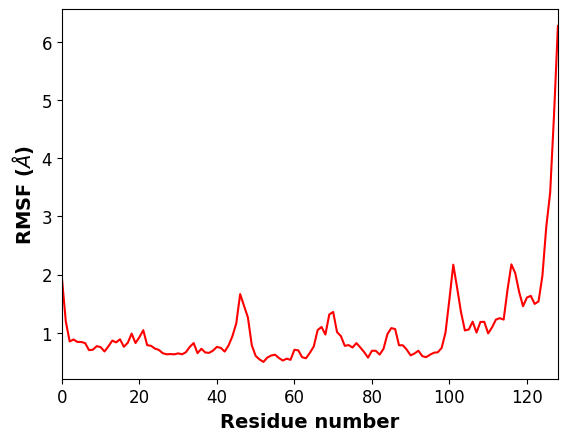

In [55]:
#@title **Plot RMSFs**

# reorder = False # @param {type:"boolean"}
#new_first_index = "0" #@param {type:"string"}
import matplotlib.pyplot as plt
import pandas as pd

resid = c_alphas.resids
#@markdown ###**Residue (c-alpha) range to plot RMSF results:**
first_plotted_residue = min(c_alphas.resids)
last_plotted_residue = max(c_alphas.resids)
Output_name = 'rmsf_ca' #@param {type:"string"}

fig, ax = plt.subplots()
colors = ['blue', 'orange', 'green', 'purple', 'red', 'brown', 'magenta']
# Plotting on the passed axes object
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
ax.plot(resid, R.results.rmsf, color='red')
ax.set_xlabel('Residue number', fontsize = 14, fontweight = 'bold')
ax.set_ylabel('RMSF ($\AA$)', fontsize = 14, fontweight = 'bold')
ax.set_xlim(int(first_plotted_residue), int(last_plotted_residue))
plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

raw_data=pd.DataFrame(R.results.rmsf)
raw_data.to_csv(os.path.join(workDir, Output_name + ".csv"))

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

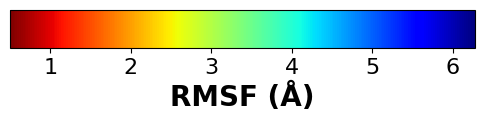

In [56]:
#@title **Save the RMSF values as custom B factors and display the 3D structure**

import py3Dmol
import matplotlib as mpl

warnings.filterwarnings("ignore")

u = mda.Universe(pdb_ref, traj)

average = align.AverageStructure(u, u, select=rmsf_sel, ref_frame=0).run()
ref = average.results.universe
aligner = align.AlignTraj(u, ref, select=rmsf_sel, in_memory=True).run()
c_alphas = u.select_atoms(rmsf_sel)
R = rms.RMSF(c_alphas).run()
rmsf_data = pd.DataFrame(R.rmsf,index=c_alphas.resnums,columns=['RMSF']) #Saving the RMSF value for every aC residue
rmsf_3d=[]
protein_write = u.select_atoms("protein")
protein_write.write("protein_bfactor.pdb")
u1=mda.Universe("protein_bfactor.pdb","protein_bfactor.pdb")
u1.add_TopologyAttr('tempfactors') #Initialization of B factors (tempfactors) by MDA in the Universe atoms
for atom in u1.atoms:
    rmsf_3d.append(rmsf_data.loc[atom.resid,'RMSF']) #A new list of RMSF must be created by ATOM. Our table has this values per aC. We can create a longer list easily
with mda.Writer(os.path.join(workDir, 'protein_rmsf.pdb'), u1) as PDB: #This is the functionality from MDA which allos us to save PDB files.
    for ts in u1.trajectory: #I'll save just the first frame in PDB as snapshot
        u1.atoms.tempfactors = rmsf_3d #This adds the custom B factors to the PDB snapshot
        PDB.write(u1.atoms)

def show_pdb(pdb_rmsf, R, analysis_range, color="RMSF"):
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
  view.addModel(open(pdb_rmsf,'r').read(),'pdb')
  u=mda.Universe(pdb_rmsf,pdb_rmsf)
  c_alphas = u.select_atoms(analysis_range)
  rmsf_data = pd.DataFrame(R.rmsf,index=c_alphas.resnums,columns=['RMSF']) #Saving the RMSF value for every aC residue

  if color == "RMSF":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':min(rmsf_data['RMSF']),'max':max(rmsf_data['RMSF'])}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    chains = len(queries[0][1]) + 1 if is_complex else 1
    for n,chain,color in zip(range(chains),list("ABCDEFGH"),
                     ["lime","cyan","magenta","yellow","salmon","white","blue","orange"]):
      view.setStyle({'chain':chain},{'cartoon': {'color':color}})

  view.zoomTo()
  return view

def bar_color(pdb_rmsf, R, analysis_range):
  u=mda.Universe(pdb_rmsf,pdb_rmsf)
  c_alphas = u.select_atoms(analysis_range)
  rmsf_data = pd.DataFrame(R.rmsf,index=c_alphas.resnums,columns=['RMSF'])
  fig, ax = plt.subplots(figsize=(6, 1))
  fig.subplots_adjust(bottom=0.5)

  cmap = mpl.cm.jet_r
  norm = mpl.colors.Normalize(vmin=min(rmsf_data['RMSF']), vmax=max(rmsf_data['RMSF']))

  cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,norm=norm,orientation='horizontal')
  cb1.set_label('RMSF (Å)',fontsize=20,fontweight='bold')
  cb1.ax.tick_params(labelsize=16)
  plt.show()
  return fig

rmsf_sel = "name CA"

show_pdb(os.path.join(workDir, 'protein_rmsf.pdb'), R, rmsf_sel, color="RMSF").show()
bar_color(os.path.join(workDir, 'protein_rmsf.pdb'), R, rmsf_sel).show()

---
# **Principal component analysis (PCA)**

Principal component analysis is a common linear dimensionality reduction technique that maps the coordinates in each frame of your trajectory to a linear combination of orthogonal vectors. The vectors are called principal components, and they are ordered such that the first principal component accounts for the most variance in the original data (i.e. the largest uncorrelated motion in your trajectory), and each successive component accounts for less and less variance. The frame-by-frame conformational fluctuation can be considered a linear combination of the essential dynamics yielded by the PCA. Please see http://www.springer.com/gp/book/9780387954424 and https://doi.org/10.1063/1.4885338, for a more in-depth introduction to PCA.

In [57]:
#@title **Calculating the Principal component analysis (PCA)**
import warnings
warnings.filterwarnings('ignore')

#@markdown **Provide inputs below:**
Selection1 = '120' #@param {type:"string"}
Selection2 = '130' #@param {type:"string"}

import MDAnalysis as mda
import MDAnalysis.analysis.pca as pca

u = mda.Universe(pdb_ref,traj)
pca_calc = pca.PCA(u, select=f'name CA and resid {Selection1}:{Selection2}')
pca_calc.run()

Cumulated variance for PC1: 0.392
Cumulated variance for PC2: 0.593
Cumulated variance for PC3: 0.703
Cumulated variance for PC4: 0.773
Cumulated variance for PC5: 0.822
Cumulated variance for PC6: 0.861
Cumulated variance for PC7: 0.891
Cumulated variance for PC8: 0.910
Cumulated variance for PC9: 0.926
Cumulated variance for PC10: 0.939


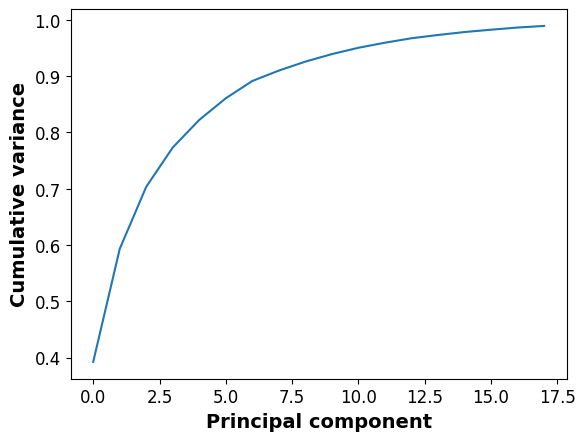

In [60]:
#@title **Calculating the Variance of Each Principal Component**
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

n_pcs = np.where(pca_calc.cumulated_variance > 0.99)[0][0]
atomgroup = u.select_atoms(f'name CA and resid {Selection1}:{Selection2}')
pca_space = pca_calc.transform(atomgroup, n_components=n_pcs)

for i in range(10):
    print(f"Cumulated variance for PC{i+1}: {pca_calc.cumulated_variance[i]:.3f}")

transformed = pca_calc.transform(atomgroup, n_components=n_pcs)
transformed.shape
df = pd.DataFrame(transformed,
                  columns=['PC{}'.format(i+1) for i in range(n_pcs)])
df['Frame'] = df.index * u.trajectory.dt

plt.plot(pca_calc.cumulated_variance[:n_pcs])
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel('Principal component', fontsize = 14, fontweight = 'bold')
plt.ylabel('Cumulative variance', fontsize = 14, fontweight = 'bold')
plt.show()

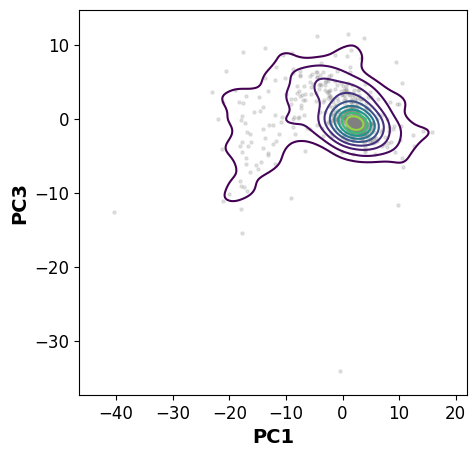

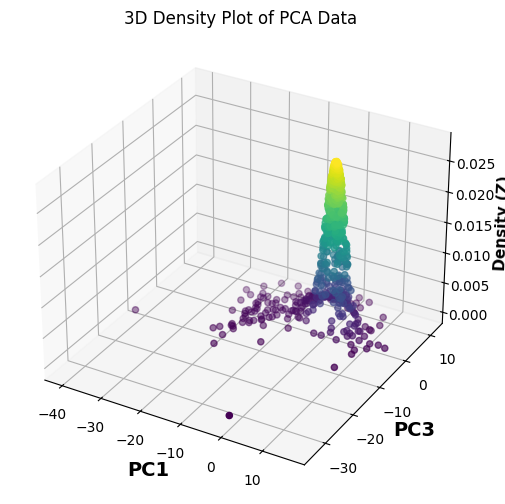

In [64]:
#@title **Plot the Principle Component Analysis (PCA)**

#@markdown **Provide which principal component you want to plot:**

PC_x = "1" #@param ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"]
PC_y = "3" #@param ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"]


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde

PC1 = df[f'PC{PC_x}'].tolist()
PC2 = df[f'PC{PC_y}'].tolist()

# Create the figure
plt.figure(figsize=(5, 5))
plt.scatter(PC1, PC2, s=5, color="gray", alpha=0.2)

# Plot a KDE contour map (no fill)
sns.kdeplot(x=PC1, y=PC2, cmap="viridis", levels=10, linewidths=1.5)

plt.xlabel(f"PC{PC_x}", fontsize = 14, fontweight = 'bold')
plt.ylabel(f"PC{PC_y}", fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

plt.savefig(os.path.join(workDir, f"PC{PC_x}_PC{PC_y}_2D.png"), dpi=600, bbox_inches='tight')

# Compute KDE
xy = np.vstack([PC1, PC2])
kde = gaussian_kde(xy)(xy)  # Evaluates the density at each point

# 3D plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(projection='3d')

# Scatter plot with Z as density
ax.scatter(PC1, PC2, kde, c=kde, cmap='viridis')

# Labels
ax.set_xlabel(f"PC{PC_x}", fontsize = 14, fontweight = 'bold')
ax.set_ylabel(f"PC{PC_y}", fontsize = 14, fontweight = 'bold')
ax.set_zlabel("Density (Z)", fontsize = 11, fontweight = 'bold')
ax.set_title("3D Density Plot of PCA Data")

# plt.show()
plt.savefig(os.path.join(workDir, f"PC{PC_x}_PC{PC_y}_3D.png"), dpi=600, bbox_inches='tight')
pc1=pd.DataFrame(PC1)
pc1.to_csv(os.path.join(workDir, f"PC{PC_x}.csv"))
pc2=pd.DataFrame(PC2)
pc2.to_csv(os.path.join(workDir, f"PC{PC_y}.csv"))